In [13]:
import streamlit as st
import datetime
from glob import glob
from PIL import Image
import numpy as np
import base64
import io
import sys
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import jaccard_score

if '../app' not in sys.path:
    sys.path.append('../app/')

from utils.locate_timings import bin_confusion, confusion2transcript
from utils.identify_theme import send2chatgpt, send2chatgpt_without_lecture, split_confused_transcripts_by_line

import re 
def convert_int(s):
    if s.isdigit():
        return int(s)
    else:
        return s


def alphanum_key(s):
    return [convert_int(c) for c in re.split('([0-9]+)', s)]


def sort_nicely(l):
    l.sort(key=alphanum_key)
from tqdm import tqdm
import seaborn as sns
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

    

In [2]:
all_transcripts_csvs = glob('../transcripts_processed/*.csv')
sort_nicely(all_transcripts_csvs)

In [3]:
all_confused_csvs = glob('../confusion_processed/*.csv')
sort_nicely(all_confused_csvs)

In [4]:
jaccard_ls = []
filename_ls = []
for selected_confused_csv, select_transcript_csv in tqdm(zip(all_confused_csvs, all_transcripts_csvs)):
    # print(selected_confused_csv, select_transcript_csv)
    avg_1min = bin_confusion(selected_confused_csv)
    transcript_with_confused_df = confusion2transcript(select_transcript_csv, avg_1min)
    confused_transcript, all_transcripts = split_confused_transcripts_by_line(transcript_with_confused_df)
    response_without = send2chatgpt_without_lecture(confused_transcript)
    response = send2chatgpt(all_transcripts, confused_transcript)
    # Sample transcripts
    transcript_a = all_transcripts.replace('\n', ' ')
    transcript_b = response_without.replace('\n', ' ')
    transcript_c = response.replace('\n', ' ')
    
    # Combine all transcripts
    transcripts = [transcript_a, transcript_b, transcript_c]
    
    # Convert to binary vectors (presence or absence of n-grams)
    vectorizer = CountVectorizer(binary=True)
    X_binary = vectorizer.fit_transform(transcripts).toarray()
    
    # Initialize a similarity matrix
    num_transcripts = len(transcripts)
    jaccard_sim_matrix = np.zeros((num_transcripts, num_transcripts))
    
    # Compute Jaccard similarity for all pairs
    for i in range(num_transcripts):
        for j in range(num_transcripts):
            if i != j:  # Skip diagonal elements
                jaccard_sim_matrix[i, j] = jaccard_score(X_binary[i], X_binary[j])
    jaccard_ls.append(jaccard_sim_matrix)
    filename_ls.append(selected_confused_csv)
    # print("Jaccard Similarity Matrix:\n", jaccard_sim_matrix)

15it [08:40, 34.68s/it]


In [5]:
filename_ls

['../confusion_processed/20190207_confusion.csv',
 '../confusion_processed/20190221_confusion.csv',
 '../confusion_processed/20190226_confusion.csv',
 '../confusion_processed/20190307_confusion.csv',
 '../confusion_processed/20190321_confusion.csv',
 '../confusion_processed/20190326_confusion.csv',
 '../confusion_processed/20190328_confusion.csv',
 '../confusion_processed/20190404_confusion.csv',
 '../confusion_processed/20190409_confusion.csv',
 '../confusion_processed/20190416_confusion.csv',
 '../confusion_processed/20190418_confusion.csv',
 '../confusion_processed/20190423_confusion.csv',
 '../confusion_processed/20190425_confusion.csv',
 '../confusion_processed/20190430_confusion.csv',
 '../confusion_processed/20190502_confusion.csv']

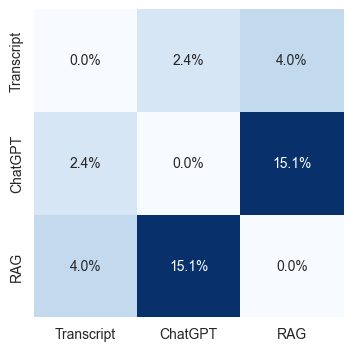

In [20]:
labels = ['Transcript', 'ChatGPT', 'RAG']
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.heatmap(np.mean(jaccard_ls, axis=0), annot=True, 
            xticklabels=labels, 
            yticklabels=labels,
            cmap='Blues',
            cbar=False, fmt='.1%')
fig.savefig('../figure_panels/jaccard_similarity_heatmap_RAG_vs_NonRAG.svg', bbox_inches='tight', dpi=300)


In [68]:
select_confused_csv = '../confusion_processed/'+str(d.year)+str(d.month).zfill(2)+str(d.day).zfill(2)+'_confusion.csv'
avg_1min = bin_confusion(select_confused_csv)

select_transcript_csv = '../transcripts_processed/' + str(d.year) + str(d.month).zfill(2) + str(d.day).zfill(
    2) + '_transcript_all.csv'

In [69]:
len(avg_1min)

80

In [70]:
transcript_with_confused_df = confusion2transcript(select_transcript_csv, avg_1min)

[5]
5
04
05
300.0
00:05:00
240.0
00:04:00


/Users/lucia/Documents/GitHub/ICSE_2025/notebooks/../app/utils/locate_timings.py:92: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.state[(df.timestamp < normalize_time(f"00:{min_zfill}:00")) &


In [71]:
transcript_with_confused_df

,timestamp,transcript,state
0,00:01:00,I'm going to jail.,Not Confused
1,00:01:00,"Oh, yeah.",Not Confused
2,00:01:01,I'm going to jail.,Not Confused
3,00:01:02,Yeah.,Not Confused
4,00:01:02,I'm going to jail.,Not Confused
...,...,...,...
1339,01:18:39,Yeah.,Not Confused
1340,01:18:40,Yeah.,Not Confused
1341,01:18:41,Yeah.,Not Confused
1342,01:19:42,Yeah.,Not Confused


In [72]:
confused_transcript, all_transcripts = split_confused_transcripts_by_line(transcript_with_confused_df)

In [73]:
response_without = send2chatgpt_without_lecture(confused_transcript)

In [74]:
response = send2chatgpt(all_transcripts, confused_transcript)

In [75]:
all_transcripts.replace('\n', ' ')

"I'm going to jail. Oh, yeah. I'm going to jail. Yeah. I'm going to jail. I'm going to jail. This is my advisor. My advisor had to get in my way. So she went to the office, and she was like, really off. Are you kidding me? Yeah. Arlino National Museum. Yeah. I'm going to jail. I'm going to jail. I'm going to jail. I'm going to jail. I put together, like, a dozen advisors, Okay, just some quick bake-off clarifications, because I've been getting a lot of the teams sort of ramped up and started asking me interesting questions, and there's some things that I've heard three or four or five times now. So number one is, I'm trying to make this more realistic and more stringent than bake-off one, and one of the ways that we're going to do that is that you have to decorate all of the destination squares the same way. So let's say you wanted to put a little dot in the middle of the square or something like that. That has to be true for all of them, okay? The only thing that I'm going to allow yo

In [76]:
response_without.replace('\n', ' ')

'**Concept: Visual Consistency in User Interface Design**  **Explanation:**   The lecture focuses on maintaining visual consistency in user interface design, particularly regarding the use of color and opacity. "Yellowing" signifies a change or transfer, while a consistent "white" color indicates uniformity. It emphasizes ensuring uniform visual treatment of destination squares, prohibiting special decorations that alter their appearance. In design applications like Keynote or Illustrator, all destination points should have the same fill color to preserve uniformity. Additionally, each trial requires retrieving user logos to ensure clarity and consistency across multiple interface elements.'

In [77]:
response.replace('\n', ' ')

'**Opacity and Related Constraints in Graphic Design Prototyping**  In graphic design prototyping, managing opacity pertains to setting transparency levels of elements, where uniformity is crucial for consistency and clarity across prototypes. The excerpt suggests you are involved in a design challenge, or "Bake Off," which involves graphics where the guidelines enforce consistent opacity across all destination squares, ensuring only fill color variations. This constraint promotes uniformity and effective communication of visual information within the design. You are further constrained from utilizing specific indicators, such as lines leading to targets, that bias the visual hierarchy or interaction pattern, maintaining visual equality among design elements. Lastly, each trial requires the designer to manually reposition a logo, emulating real-world interaction scenarios where graphical elements are independently manipulated rather than pre-affixed.'

In [50]:
transcript_with_confused_df['state']

0      Not Confused
1      Not Confused
2      Not Confused
3      Not Confused
4      Not Confused
           ...     
800    Not Confused
801    Not Confused
802    Not Confused
803    Not Confused
804    Not Confused
Name: state, Length: 805, dtype: object

In [51]:
confused_transcript

"You might have to be out a little bit.\nTry not to be right here.\nOkay.\nThank you for being here.\nI'm sure most of you are comfortable with your team.\nAnd I'll be here.\nI will be playing my game.\nAs long as I don't have to.\nI'll be here.\nYou guys can talk to each other.\nYou don't have to worry about it.\nI'll be here.\nSo...\nI'll be here.\nI'll be here.\nI'll be here.\nI'll be here.\nI'll be here.\nI'll be here.\nMeet me.\nMeet me.\nI'll be there.\nI'll be there.\nMeet me.\nMeet me.\nI'll be there.\nI'll be there.\nMeet me.\nMeet me.\nMeet me.\nI'll be there.\nMeet me.\nMeet me.\nMeet me.\nMeet me.\nI'll be there.\nMeet me.\nMeet me.\nMeet me.\nMeet me.\nI'll be there.\nMeet me.\nMeet me.\nI'll be there.\nmeet.meet.meet.meet.\nhour.\nhour.\nalarm.\nnow.\nHall.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nNow.\nSo you can go ahead and modify your code right now and set numberRepeat equals to 3.\

In [85]:
# Sample transcripts
transcript_a = all_transcripts.replace('\n', ' ')
transcript_b = response_without.replace('\n', ' ')
transcript_c = response.replace('\n', ' ')

# Combine all transcripts
transcripts = [transcript_a, transcript_b, transcript_c]

# Convert to binary vectors (presence or absence of n-grams)
vectorizer = CountVectorizer(binary=True)
X_binary = vectorizer.fit_transform(transcripts).toarray()

# Initialize a similarity matrix
num_transcripts = len(transcripts)
jaccard_sim_matrix = np.zeros((num_transcripts, num_transcripts))

# Compute Jaccard similarity for all pairs
for i in range(num_transcripts):
    for j in range(num_transcripts):
        if i != j:  # Skip diagonal elements
            jaccard_sim_matrix[i, j] = jaccard_score(X_binary[i], X_binary[j])

print("Jaccard Similarity Matrix:\n", jaccard_sim_matrix)



Jaccard Similarity Matrix:
 [[0.         0.02208955 0.02654867]
 [0.02208955 0.         0.19117647]
 [0.02654867 0.19117647 0.        ]]


In [6]:
f = open('../figure_panels/confused_transcript_0221.txt', 'w')
f.write(confused_transcript)

26833

In [7]:
confused_transcript

"but you've considered it. Okay, 45 seconds. How many people have done it? Raise your hand if you've done it. Okay, 10 newtons. Okay, start passing them in. How many people thought this one was easier than the last one? Raise your hand. That's not what we're doing. We just went over the material last lecture. It's easier. Okay, got them all, yes? The file is closing in five seconds. Yes, is there one more? Okay, last call, yes? Okay, very quickly we get the answer. So, one of the two HCI monikers, the first one being know thy user, the second HCI moniker is user is not like me. Right, recognizing that people are different. How many people put user not like me? Okay, with surveys. In an online survey, like SurveyMonkey, you're just calling up phone numbers. You generally learn. You know you can call thousands, because you can blast a meme of a thousand people, so hopefully people know that it's a thousands of people, but it would be weird to send a SurveyMonkey to just two people you ca